In [87]:
# Python 3.10.8

#https://nbviewer.org/github/SHTOOLS/SHTOOLS/blob/master/examples/notebooks/grids-and-coefficients.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from geomstats.geometry.hypersphere import Hypersphere
import geomstats.visualization as visualization

# Our functions are gathered in :
import functions 


from scipy.stats import vonmises_fisher # One-dimensional vMF on the circle
def sampleTangentvMF(n_samples):
    m1 = np.array([0,0,1])
    V = np.random.beta(2,8,size=n_samples)
    Z = 2*V -1 
    S = np.zeros((n_samples,3))
    S[:,0:2] = vonmises_fisher(mu=np.array([1,0]),kappa=15).rvs(n_samples)
    data1 = Z.reshape(n_samples,1)*m1 + np.sqrt(1-Z**2).reshape(n_samples,1)*S
    return(data1)

In [88]:

n_samples = 2001

#dataA = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,-0.5,np.sqrt(0.75)]),kappa=20, n_samples=int(n_samples*0.7))
#dataB = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0.5,np.sqrt(0.75)]),kappa=20, n_samples=int(n_samples*0.3))
#data = np.concatenate([dataA,dataB])


#data = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([1,0,0]),kappa=20, n_samples=n_samples)

data = sampleTangentvMF(n_samples)
data = functions.rotateData(data,functions.func_Frechetmean(data))

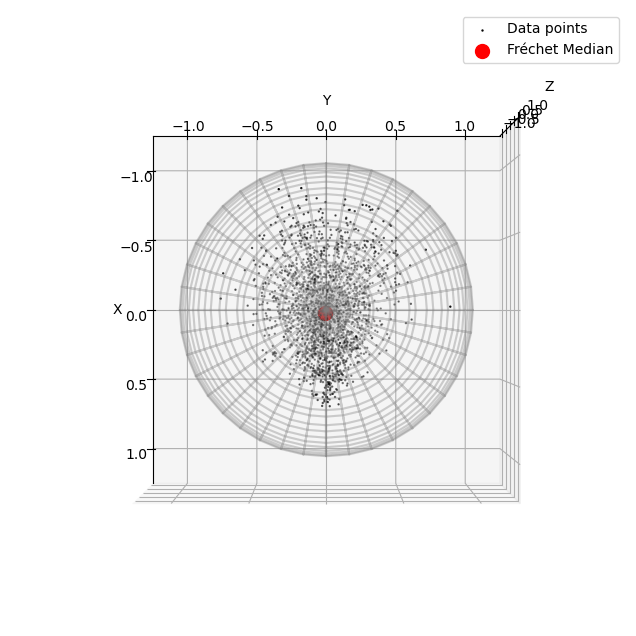

In [89]:
MeanData = functions.func_GeomMedian(data) 

fig = plt.figure(figsize=(8, 8)) 
ax = visualization.plot(data, space="S2", color="black", s=0.5, label="Data points")
ax = visualization.plot(MeanData.reshape(1,3), space="S2", color="red",alpha=1,s=100, label="Fréchet Median",)
ax.set_box_aspect([1, 1, 1]) 
ax.legend()
el = 90
az = 0
ax.view_init(el,az)

# 1) Solving OT problem

In the next cell, key parameters are the regularization `eps`, and the number of epochs for gradient descent, that performs `epoch*n` iterations for `n` observations in the data. 

The first thing to do in case of any bug is to take a bigger `epoch` to increase the number of iterations.

Through the dual potential, one can estimate the Wasserstein distance. Plotting this estimate with respect to the iterations indicates on the convergence of the algorithm.

The implementation of our stochastic algorithm in the function `Robbins_Monro_Algo` in the doc `functions` calculates recursively the Wasserstein distance, which may take time.
The following cell solves OT in the shortest way, without additional calculations. 

In [76]:
eps = 0.1 # regularization parameter
N_epoch = 30

# Robbins-Monro / Stochastic gradient descent 
u = functions.Robbins_Monro_Algo_faster(Y=data, eps=eps, gamma= 1, c = 0.51, epoch = N_epoch,l_max=30)


The resulting object is a Kantorovich dual potential from which the Monge mapping is defined. 
It can be visualized as follows, with blue areas being the lowest values, and red areas being the highest values.

Text(0.5, 1.0, 'Kantorovich dual potential')

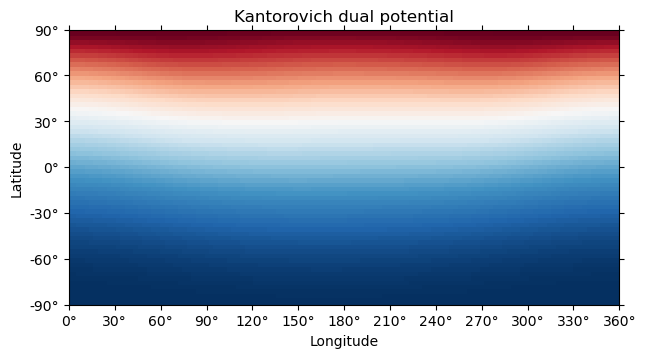

In [77]:
fig, ax = u.plot(cmap='RdBu',
                    cmap_reverse=True,
                    show=False)
plt.title("Kantorovich dual potential")

This Kantorovich dual potential can be compared with the data, to verify its coherence. 

As in the euclidean case, the gradient of the convex function $u$ at $x$ is directed to minimizers of $u$. Thus, at any point $x$ in the figure above, it shall be directed towards areas **more blue**.
But differentiation of the Kantorovich potential gives the Monge map $Q$ from the uniform distribution on the sphere to the data points, and we expect the images $Q(x) \in \mathbb{S}^{2}$ to cover the data points. 

Consequently, **data is expected to lie in the blue areas of the figure above**.
The following figure shows that this is indeed the case.
In addition to the data points in green and the Fréchet Median in red, a colormap illustrates the squared Riemannian distance $c(x,m)$, with respect to the Fréchet Median $m$, of every point $x$ in the sphere.


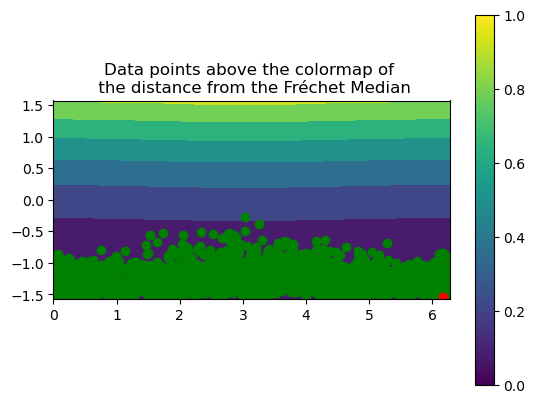

In [78]:
v_lat = u.lats()*np.pi/180 #from degrees to radians
v_lon = u.lons()*np.pi/180 

C = functions.cost_fft2(u,MeanData)
h = plt.contourf(v_lon, v_lat, C)
yc = functions.cartesian2polar(data.T)
plt.scatter(yc[0],yc[1],color='green')
yc = functions.cartesian2polar(MeanData)
plt.scatter(yc[0],yc[1],color='red')
plt.axis('scaled')
plt.title("Data points above the colormap of \n the distance from the Fréchet Median")
plt.colorbar()
plt.show()


# Quantile contours and sign curves

It only remains to take the image by the quantile function of the reference contours and sign curves.. 

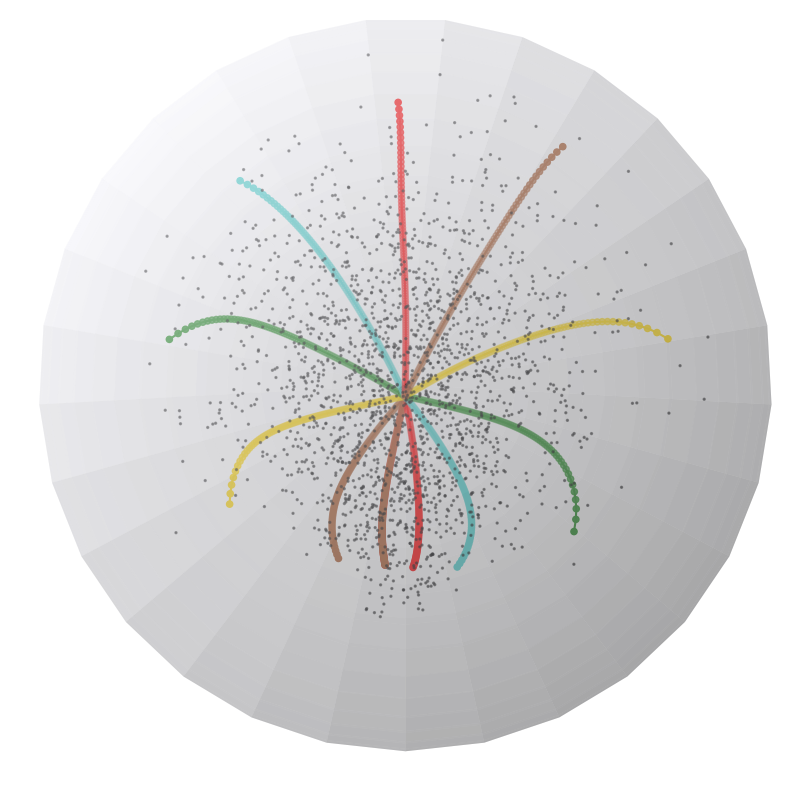

In [79]:

def plotQ_SC(longits, u,data,eps,el=90,az=45,size=100,dots=False): 
    '''
    - rayons contains the desired levels for quantile contours 
    - longits contains the desired longitudes for sign curves
    - u is the SHgrid object for the fourier serie of the Kantorovich potential
    - rotateddata contains the data oriented to the north pole
    - k is the unit vector for rotating back the data to its original position 
    '''
    ########
    colors = ["red",'#a65628',"gold","forestgreen","mediumturquoise"]*5
    MeanData = functions.func_GeomMedian(data) 
    F_thetaM = functions.Fentropic(MeanData,u,eps)

    plt.figure(figsize=(10,10))
    ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
    functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)
    functions.plot_3d_scatter(MeanData.reshape(1,3) ,ax,colour="black",sz=100,alpha=1)
    
    for i,LON in enumerate(longits):
        points = functions.signcurve_unif_rotated(F_thetaM,LON,size=size+10)[:(size)]
        df = functions.QentropicBP_pts(points,u,data,eps)
        ax.plot(df[:,0],df[:,1],df[:,2],c=colors[i])
        if dots==True:
            ax.scatter(df[:,0],df[:,1],df[:,2],c=colors[i])


N = 12
longits = np.linspace(0,2*np.pi,N)[:N] 
plotQ_SC(longits, u,data,eps,el,az,size=100,dots=True) 

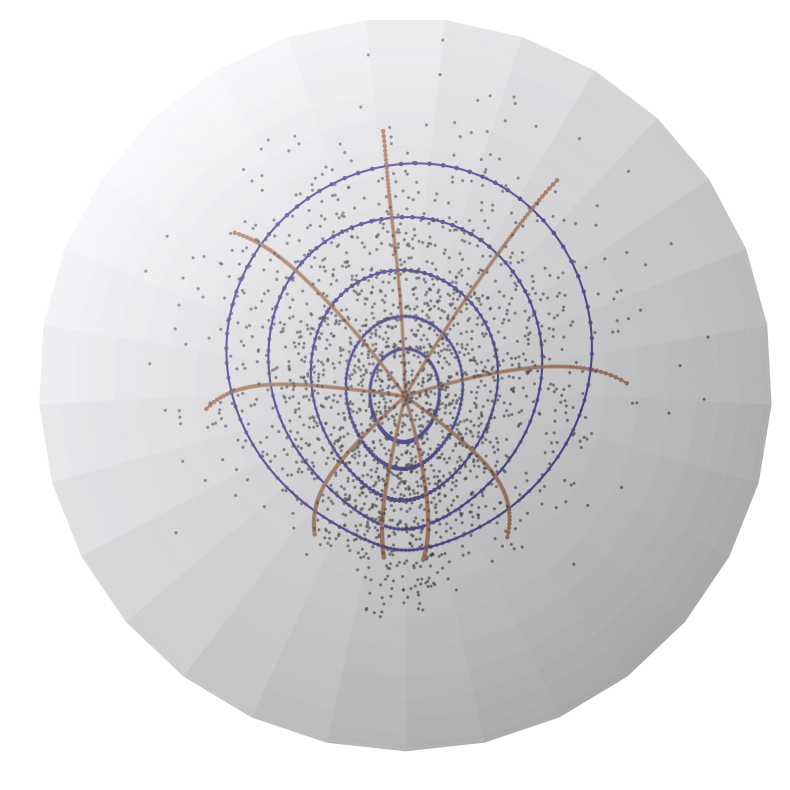

In [80]:

def plotQcontoursSC(rayons,longits, u,data,eps,el=90,az=45,size=100,dots=False): 
    '''
    - rayons contains the desired levels for quantile contours 
    - longits contains the desired longitudes for sign curves
    - u is the SHgrid object for the fourier serie of the Kantorovich potential
    - rotateddata contains the data oriented to the north pole
    - k is the unit vector for rotating back the data to its original position 
    '''
    ########
    MeanData = functions.func_GeomMedian(data) 
    F_thetaM = functions.Fentropic(MeanData,u,eps)

    plt.figure(figsize=(10,10))
    ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
    functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)
    #plot_3d_scatter(MeanData.reshape(1,3) ,ax,colour="black",sz=100,alpha=1)

    for i,tau in enumerate(rayons):
        points = functions.contour_unif_rotated(F_thetaM,tau,size=size)
        df = functions.QentropicBP_pts(points,u,data,eps)
        ax.plot(df[:,0],df[:,1],df[:,2],c="navy")
        if dots==True:
            ax.scatter(df[:,0],df[:,1],df[:,2],c="navy",s=5)
    
    for i,LON in enumerate(longits):
        points = functions.signcurve_unif_rotated(F_thetaM,LON,size=size+15)[:(size)]
        df = functions.QentropicBP_pts(points,u,data,eps)
        ax.plot(df[:,0],df[:,1],df[:,2],c="#a65628")
        if dots==True:
            ax.scatter(df[:,0],df[:,1],df[:,2],c="#a65628",s=5)



N = 10
rayons = [0.1,0.25,0.5,0.75,0.9]
longits = np.linspace(0,2*np.pi,N)[1:]
plotQcontoursSC(rayons,longits, u,data,eps,el,az,size=100,dots=True)

# Ground-truth contours

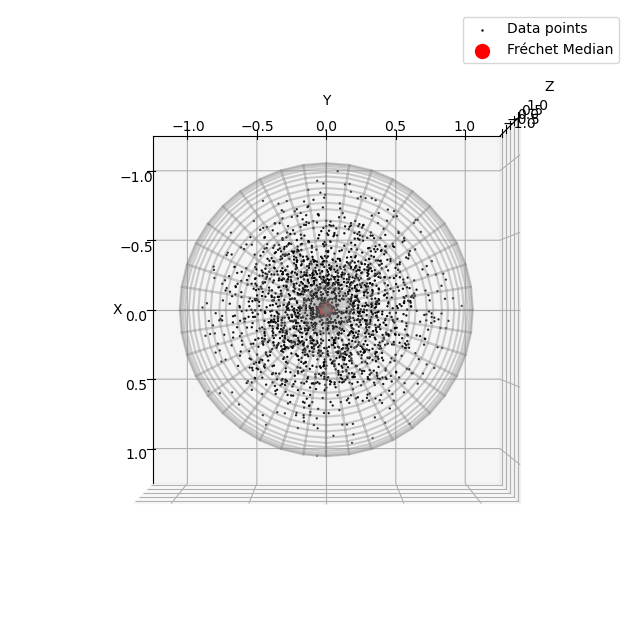

In [40]:
# 1) sample 
n_samples = 2001 
kappa = 10
data = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0,1]),kappa=kappa, n_samples=n_samples)

MeanData = functions.func_GeomMedian(data) 

fig = plt.figure(figsize=(8, 8)) 
ax = visualization.plot(data, space="S2", color="black", s=0.5, label="Data points")
ax = visualization.plot(MeanData.reshape(1,3), space="S2", color="red",alpha=1,s=100, label="Fréchet Median",)
ax.set_box_aspect([1, 1, 1]) 
ax.legend()
el = 90
az = 0
ax.view_init(el,az)


In [44]:
# Functions for ground truth contours : 
def inv_Ff_star(b,kappa):
    toto = (b+1)/2 * (np.exp(kappa)- np.exp(-kappa)) + np.exp(-kappa)
    toto = np.log(toto) / kappa
    return(toto)

def Ff_star(a,kappa):
    toto = (np.exp(a * kappa)- np.exp(-kappa)) / (np.exp(kappa)- np.exp(-kappa))
    toto = 2 * toto - 1
    return(toto)

def Q_vMF(points,kappa):
    res = []
    for p in points:
        phi,tht = functions.cartesian2polar(p) 
        z3 = inv_Ff_star(p[2],kappa)
        thtnew = np.arccos(z3)
        thtnew = np.pi/2 - thtnew
        p = functions.polar2cartesian(phi=phi,theta=thtnew)
        res.append( p )
    return(np.array(res))

N = 10 
rayons = np.array([0.1,0.25,0.5,0.75,0.9])
nS = 500 #nb of points by contour and by sign curve
longits = np.linspace(0,2*np.pi,N)[1:]

contours = []
for tau in rayons:
    points = functions.contour_unif(tau,size=nS)
    contours.append(Q_vMF(points,kappa))
contours = np.array(contours).reshape(len(rayons)*nS,3)

signcurves = []
for LON in longits:
    points = functions.signcurve_unif(LON,size=nS+15)[:nS]
    signcurves.append(Q_vMF(points,kappa))
signcurves = np.array(signcurves).reshape(len(longits)*nS,3)
    

<Axes3D: >

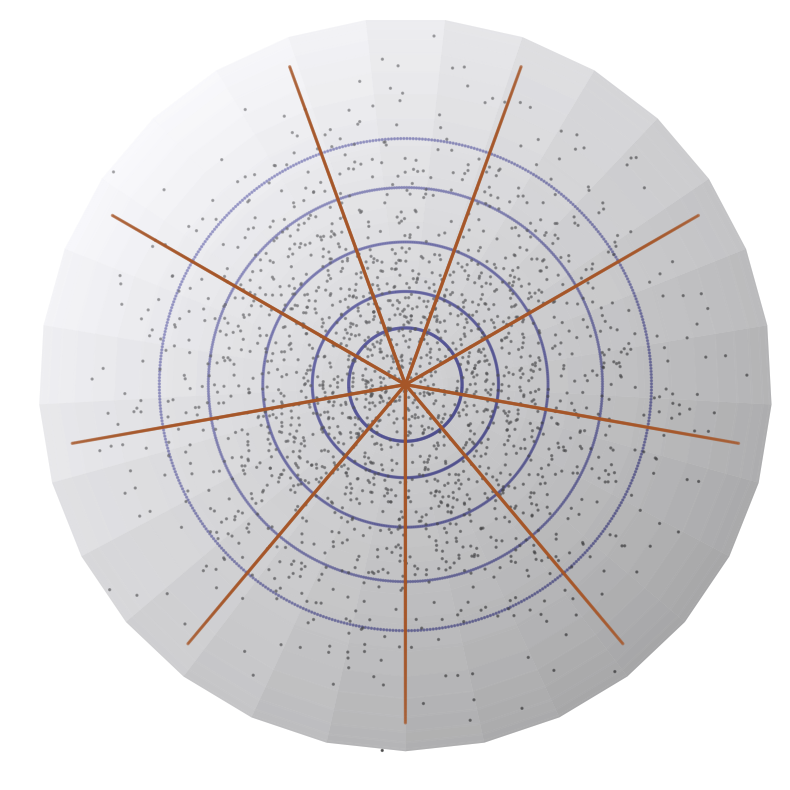

In [45]:
plt.figure(figsize=(10,10))
ax = functions.def_ax_sphere3D(el=90,az=0,sph_alpha=0.3)
functions.plot_3d_scatter(data ,ax,colour="black",sz=2,alpha=0.5)
functions.plot_3d_scatter(contours ,ax,colour="navy",sz=2,alpha=0.5)
functions.plot_3d_scatter(signcurves ,ax,colour='#a65628',sz=2,alpha=0.5)